# Applied Machine Learning
## Train your first machine learning model
- Author: Lorien Pratt
- Copyright: Quantellia LLC 2019.  All Rights Reserved

## Setup

In [1]:
my_initials<-"nm" # Set your initials to use for model and data files

##### Install and initialize the H2O library, which we will use to do the grid search
Note that this will generate a lot of warnings. These are expected, and not errors but rather notifications

In [2]:
require(h2o)
h2o.init()

Loading required package: h2o

----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit http://docs.h2o.ai

----------------------------------------------------------------------


Attaching package: ‘h2o’

The following objects are masked from ‘package:stats’:

    cor, sd, var

The following objects are masked from ‘package:base’:

    &&, %*%, %in%, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc



 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         22 hours 36 minutes 
    H2O cluster timezone:       Etc/UTC 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.26.0.10 
    H2O cluster version age:    6 days  
    H2O cluster name:           H2O_started_from_R_jupyter_mcy252 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   0.32 GB 
    H2O cluster total cores:    1 
    H2O cluster allowed cores:  1 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4 
    R Version:                  R version 3.6.1 (2019-07-05) 



Install a number of R packages we'll need to display the results

In [3]:
# This will generate what look like warnings, but are really notifications
# uncomment install.packages if you are on a new instance without these packages pre-installed
#install.packages("plyr")
#install.packages("pROC")
#install.packages("SDMTools")
#install.packages("RColorBrewer")
#install.packages("gplots")
require(plyr)
require(pROC)
require(SDMTools)
require(RColorBrewer)
require(gplots)

Loading required package: plyr
Loading required package: pROC
Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following object is masked from ‘package:h2o’:

    var

The following objects are masked from ‘package:stats’:

    cov, smooth, var

Loading required package: SDMTools
Registered S3 method overwritten by 'R.oo':
  method        from       
  throw.default R.methodsS3

Attaching package: ‘SDMTools’

The following object is masked from ‘package:pROC’:

    auc

Loading required package: RColorBrewer
Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess



Create the file names from your initials, just as we did when building the files in the first place

In [4]:
train_filename<-paste0("data/",my_initials,"_train_auto.csv"); print( train_filename )
test_filename<-paste0("data/",my_initials,"_test_auto.csv"); print( test_filename )
backtest_filename<-paste0("data/",my_initials,"_backtest_auto.csv"); print( backtest_filename )

[1] "data/nm_train_auto.csv"
[1] "data/nm_test_auto.csv"
[1] "data/nm_backtest_auto.csv"


Read in the test and training files you created in the previous step. Convert them to h2o files along the way.

In [5]:
train_hex <- h2o.importFile(train_filename, parse = TRUE, header = TRUE, 
                            sep = "", col.names = NULL, col.types = NULL, na.strings = NULL)
test_hex <- h2o.importFile(test_filename, parse = TRUE, header = TRUE, 
                           sep = "", col.names = NULL, col.types = NULL, na.strings = NULL)
backtest_hex <- h2o.importFile(backtest_filename, parse = TRUE, header = TRUE, 
                           sep = "", col.names = NULL, col.types = NULL, na.strings = NULL)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


Set a number of configuration parameters for model training

In [18]:
config_epochs=30.0
config_hidden=c(5)
config_input_dropout_ratio = 0.01
config_l1=1.0E-5
config_l2=0.01

**Tell the model training which of the columns are predictors.**
First, let's looK at the top of the dataset again to remind us of the structure...

In [19]:
head(train_hex)

car.name,cylinders,displacement,horsepower,weight,acceleration,model.year,origin,mpg
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ford country squire (sw),8,351,142,4054,14.3,79,1,15.5
plymouth duster,6,198,95,3102,16.5,74,1,20.0
saab 99le,4,121,115,2671,13.5,75,2,25.0
amc matador (sw),8,304,150,3892,12.5,72,1,15.0
pontiac phoenix,4,151,90,2735,18.0,82,1,27.0
ford fairmont,4,140,88,2870,18.1,80,1,26.4


Set the predictor columns and check that they're the right ones

In [20]:
predictors <- c(2,3,4,5,6,7,8)
names(train_hex)[predictors]

[1] "cylinders"    "displacement" "horsepower"   "weight"       "acceleration"
[6] "model.year"   "origin"

Tell the model training which of the columns is the target column (in this case, the very last column, mpg)

In [21]:
targetcol<-ncol(train_hex)
names(train_hex)[targetcol]

[1] "mpg"

Train the model

In [22]:
model  <- h2o.deeplearning(
    x = predictors,
    y = targetcol,
    variable_importances=TRUE,
    model_id='model_1',
    training_frame=train_hex,
    validation_frame = test_hex,
    quiet_mode=FALSE,
    export_weights_and_biases=TRUE,
    activation="Tanh",              # Linear outputs
    autoencoder=FALSE,
    ignore_const_cols=F,
    train_samples_per_iteration=0,
    stopping_tolerance = 1e-5,
    classification_stop = -1,       # Disable automatic stopping
    adaptive_rate=F,                # Manaully tuned learning rate
    reproducible=T,
    epochs=config_epochs,
    hidden=config_hidden,
    input_dropout_ratio = config_input_dropout_ratio, 
    l1=config_l1,
    l2=config_l2
  )

  |======================================================================| 100%


##### Plot how the error changed for the train and test set during learning. H2O calls the test set "Validation".

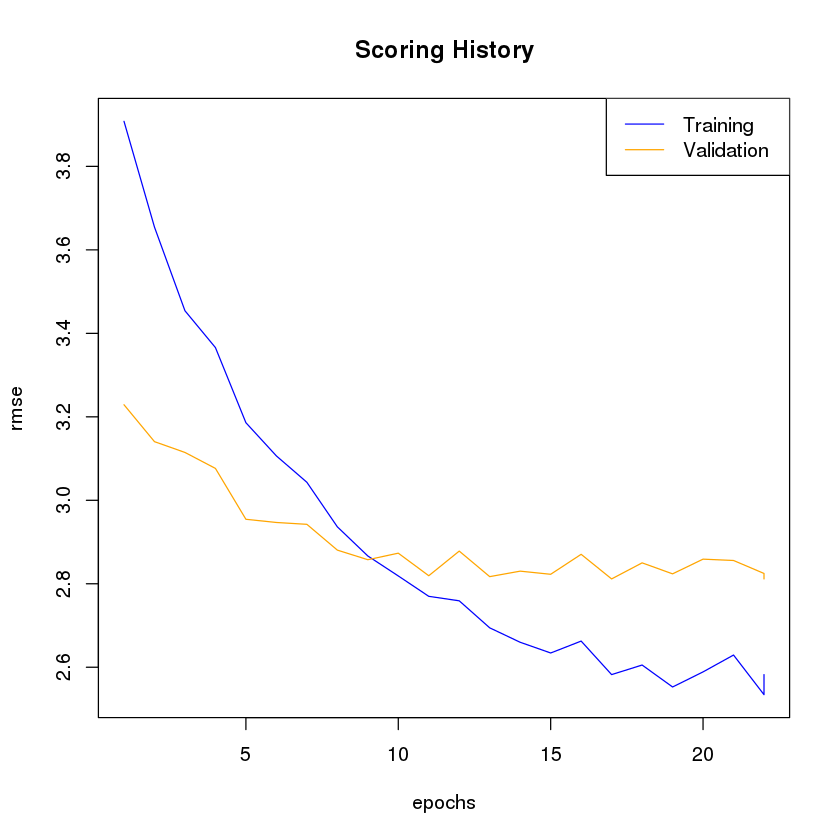

In [23]:
plot(model, timestep="epochs", metric="RMSE")

## Model evalution

Generate predictions for every row in the backtest set, and create two vectors: one with the truth and one with the prediction

In [24]:
predictions <- h2o.predict(model, backtest_hex)
#actual_column <- as.logical(as.vector(as.numeric(backtest_hex[ ,ncol(backtest_hex)])))
actual_column <- as.vector(as.numeric(backtest_hex[targetcol]))
predict_column <- as.vector(predictions[ ,'predict'])
str(actual_column)
str(predict_column)

  |======================================================================| 100%
 num [1:127] 23.7 24.2 34 15 34.7 14 16 26 21 26 ...
 num [1:127] 30.5 29.5 30.3 12 34 ...


Plot actuals versus predictions to get a visual sense of how well the model did

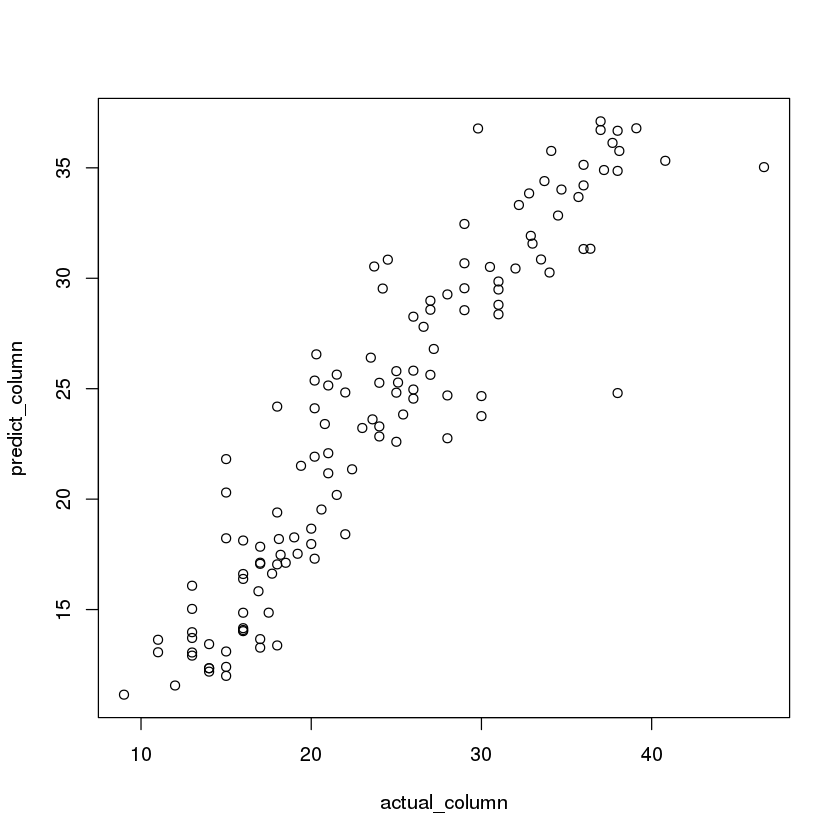

In [25]:
plot(actual_column,predict_column)

Analyze the data shown above to obtain a numerical measure of the quality of the fit.  Focus: adjusted R-squared.

In [26]:
summary(lm(predict_column~actual_column))


Call:
lm(formula = predict_column ~ actual_column)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.9013  -1.7167  -0.0504   1.5742   8.1167 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)    3.08707    0.80409   3.839 0.000195 ***
actual_column  0.85835    0.03168  27.094  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.904 on 125 degrees of freedom
Multiple R-squared:  0.8545,	Adjusted R-squared:  0.8533 
F-statistic: 734.1 on 1 and 125 DF,  p-value: < 2.2e-16


Extract the variable importances from the model and show them in a graph from most important to least important

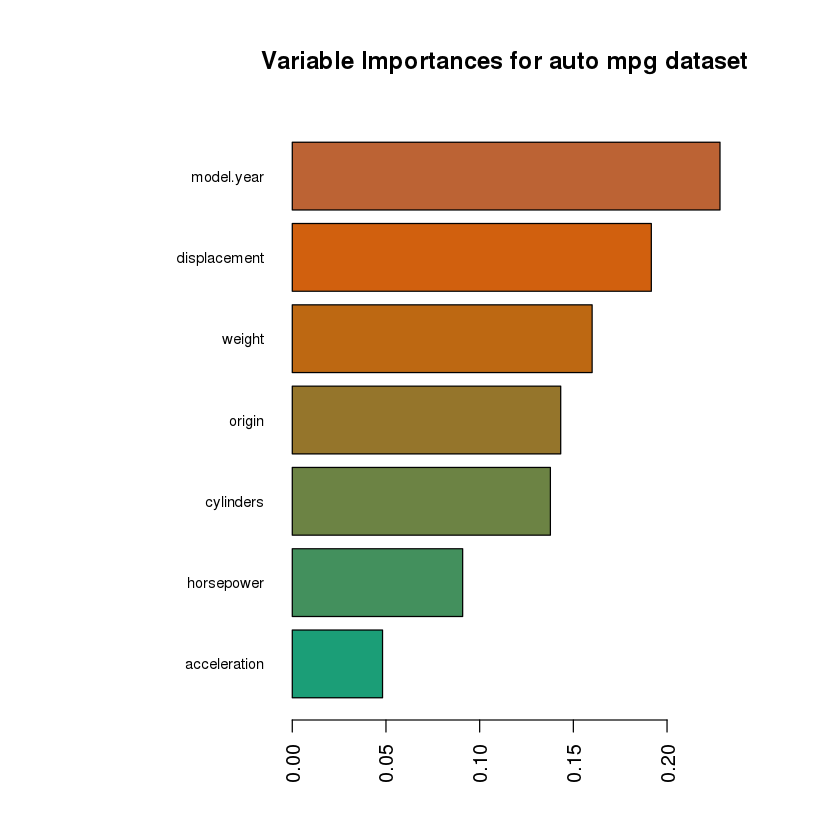

In [27]:
x<-model@model
vi<-x$variable_importances
par(mar=c(5, 12, 5, 5))
plotSize<-15
cols <- colorRampPalette(brewer.pal(4,"Dark2"))(plotSize)
barplot(rev(vi$percentage),las=2,main="Variable Importances for auto mpg dataset",
                    names.arg=rev(vi$variable),
                    horiz=TRUE,cex.names=0.75,col=cols)

###### 11. Create the ROC graph along with its AUC

In [28]:
# Note this is a regression, not a classification problem, so ROC doesn't make sense
# Saving the code here so you can use this for a classification model later
# 
#rocp1 <- roc(actual_column, predict_column,
#        percent=TRUE,
#        plot=TRUE, auc.polygon=TRUE, max.auc.polygon=TRUE, grid=TRUE,
#        print.auc=TRUE, show.thres=TRUE, main="ROC Graph: Actuals vs. Predictions")

##### Save your trained model. We'll use it later for inference. 

In [29]:
model_filename<-paste0("models/",my_initials,"_auto_model")
h2o.saveModel(model, model_filename, force=T)

[1] "/home/jupyter/Applied ML course/models/nm_auto_model/model_1"